In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random
import pandas as pd
import seaborn as sns
import re


traindir = '../../T_DEV_810/dataset/train'
valdir = '../../T_DEV_810/dataset/val'
testdir = '../../T_DEV_810/dataset/test'

In [2]:
traindatagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valdatagen = ImageDataGenerator(rescale=1./255)
testdatagen = ImageDataGenerator(rescale=1./255)

traingenerator = traindatagen.flow_from_directory(
    traindir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
valgenerator = valdatagen.flow_from_directory(
    valdir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)
testgenerator = testdatagen.flow_from_directory(
    testdir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4900 images belonging to 2 classes.
Found 1050 images belonging to 2 classes.
Found 1050 images belonging to 2 classes.


In [3]:
def create_vgg16_model():
    convbase = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    for layer in convbase.layers[:-4]:
        layer.trainable = False
    model = models.Sequential([
        convbase,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model

In [4]:
def plot_learning_curves(history, modelname):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f"{modelname} - Précision")
    plt.xlabel("Époque")
    plt.ylabel("Précision")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f"{modelname} - Perte")
    plt.xlabel("Époque")
    plt.ylabel("Perte")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{modelname}_learningcurves.png")
    plt.show()

In [5]:
def plot_binary_confusion_matrix(y_true, y_pred_proba, modelname):
    y_pred = (y_pred_proba > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité")
    plt.title(f"Matrice de confusion - {modelname}")
    plt.tight_layout()
    plt.savefig(f"{modelname}_confusionmatrix.png")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1score = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    print(f"Métriques - {modelname}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1score:.4f}")

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1score": f1score
    }


In [6]:
def plot_roc_curve(y_true, y_pred_proba, modelname):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title(f"Courbe ROC - {modelname}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(f"{modelname}_roccurve.png")
    plt.show()
    return roc_auc

In [7]:
def test_random_images(model, testdir, num_images=5):
    available_classes = [d for d in os.listdir(testdir) if os.path.isdir(os.path.join(testdir, d))]
    for i in range(num_images):
        selected_class = random.choice(available_classes)
        classdir = os.path.join(testdir, selected_class)
        imagefiles = [f for f in os.listdir(classdir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        if not imagefiles:
            continue
        randomimagefile = random.choice(imagefiles)
        imagepath = os.path.join(classdir, randomimagefile)
        img = tf.keras.preprocessing.image.load_img(imagepath, target_size=(150, 150))
        imgarray = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        imgarray = np.expand_dims(imgarray, axis=0)
        prediction = model.predict(imgarray)[0][0]
        predicted_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
        plt.figure(figsize=(10, 8))
        plt.imshow(plt.imread(imagepath))
        plt.axis('off')
        resulttext = f"Fichier: {randomimagefile}\nClasse réelle: {selected_class}\nPrédiction: {predicted_class}\nProbabilité de pneumonie: {prediction:.2f}"
        plt.title(resulttext, fontsize=12)
        plt.tight_layout()
        plt.savefig(f"random_image_prediction_{i}.png")
        plt.show()

## 4. Fonctions d'Évaluation et de Visualisation

### 📊 Visualisation des courbes d'apprentissage

Cette fonction permet de suivre l'évolution des performances du modèle durant l'entraînement :

```python
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))
    
    # Courbe d'accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Précision')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    
    # Courbe de loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Perte')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curves.png')
    plt.show()
```

**Objectifs :**
- 🎯 **Suivre la convergence** : Vérifier que le modèle apprend progressivement
- 🚨 **Détecter le surapprentissage** : Identifier l'écart entre train et validation
- 📈 **Optimiser les hyperparamètres** : Ajuster le nombre d'époques

### 🏷️ Classification des types de pneumonie

```python
def get_pneumonia_type(filename):
    if "bacteria" in filename.lower():
        return "PNEUMONIA_BACTERIAL"
    elif "virus" in filename.lower():
        return "PNEUMONIA_VIRAL"
    else:
        return "PNEUMONIA_UNKNOWN"
```

**Utilité :** Différencier les pneumonies bactériennes des virales pour une analyse plus fine.

### 🔍 Matrice de confusion et métriques

```python
def plot_binary_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred > 0.5)
    # ... code de visualisation ...
    
    # Calcul des métriques
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # Sensibilité/Rappel
    specificity = tn / (tn + fp)  # Spécificité
    precision = tp / (tp + fp)    # Précision
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
```

**Métriques clés pour le diagnostic médical :**
- **Sensitivity (Sensibilité)** : Capacité à détecter les vrais positifs (pneumonies)
- **Specificity (Spécificité)** : Capacité à identifier les vrais négatifs (cas normaux)
- **Precision** : Proportion de vrais positifs parmi les cas détectés comme positifs
- **F1-Score** : Harmonie entre précision et sensibilité

### 📈 Courbe ROC et AUC

```python
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    # ... code de visualisation ...
    return roc_auc
```

**Intérêt de la courbe ROC :**
- 🎯 **Évaluation globale** : Performance du modèle à tous les seuils
- 📊 **AUC (Area Under Curve)** : Métrique unique de performance (0.5 = aléatoire, 1.0 = parfait)

### 🔬 Analyse détaillée par type de pneumonie

Cette fonction analyse les prédictions en distinguant les types de pneumonie :

**Fonctionnalités :**
- ✅ Calcul de la précision par catégorie (Normal, Bactérienne, Virale)
- 📊 Matrice de confusion 3-classes
- 📈 Graphiques de précision par type

### 🎲 Test sur images aléatoires

```python
def test_random_images(model, test_dir, num_images=5):
    # Sélection aléatoire d'images pour tester le modèle
    # Affichage des prédictions avec les images
```

**Utilité :** Validation qualitative du modèle sur des exemples concrets.

---

Résumé du modèle VGG16


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

c:\Users\fourq\Documents\T-DEV-810-NCE_2\mon_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.8052 - loss: 0.3928 - val_accuracy: 0.8924 - val_loss: 0.2436 - learning_rate: 1.0000e-04
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9267 - loss: 0.1976 - val_accuracy: 0.9162 - val_loss: 0.2230 - learning_rate: 1.0000e-04
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9441 - loss: 0.1558 - val_accuracy: 0.9076 - val_loss: 0.2475 - learning_rate: 1.0000e-04
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9421 - loss: 0.1506 - val_accuracy: 0.9610 - val_loss: 0.1389 - learning_rate: 1.0000e-04
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.9434 - loss: 0.1512 - val_accuracy: 0.9533 - val_loss: 0.1292 - learning_rate: 1.0000e-04
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 576s 4s/step - accuracy: 0.9415 - loss: 0.1526 - val_accuracy: 0.9324 - val_loss: 0.2139 - learning_rate: 1.0000e-04
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accur

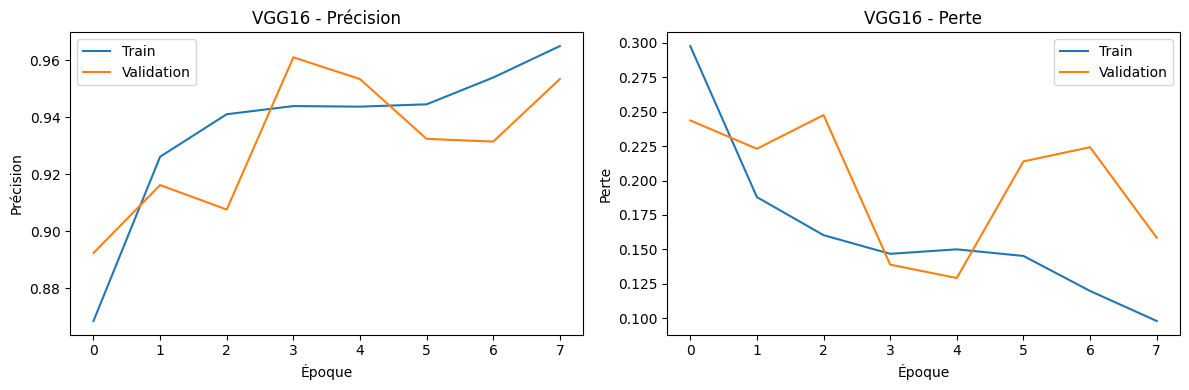

Évaluation du modèle VGG16
33/33 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9652 - loss: 0.0934
Précision du VGG16 sur le jeu de test : 0.9505
33/33 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


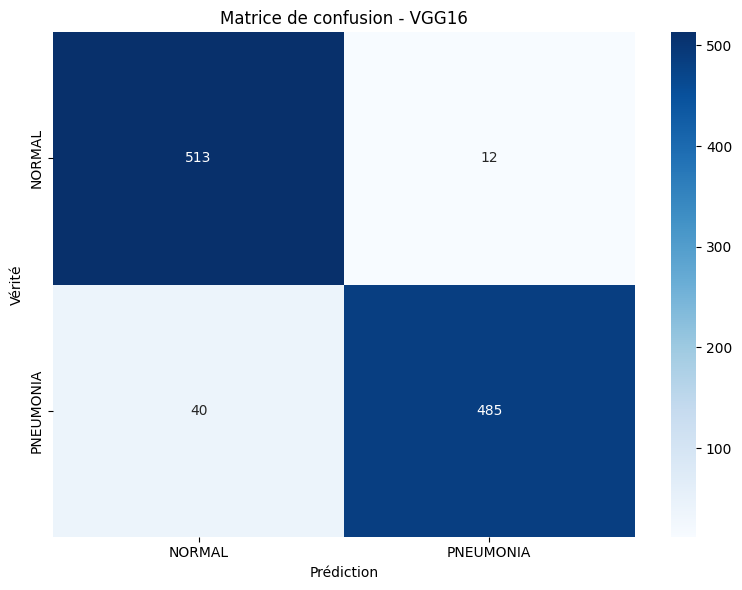

Métriques - VGG16
Accuracy: 0.9505
Sensitivity (Recall): 0.9238
Specificity: 0.9771
Precision: 0.9759
F1-Score: 0.9491


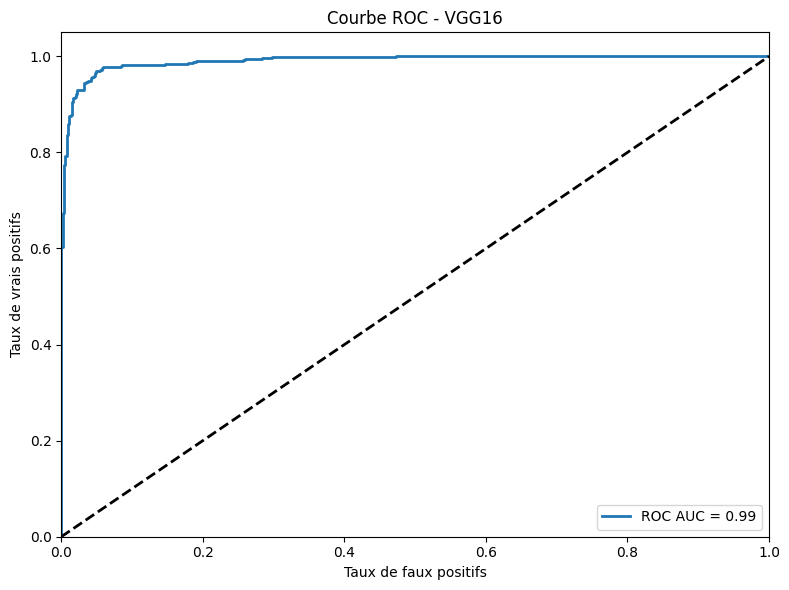

AUC : 0.991
Prédictions sur images aléatoires :
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


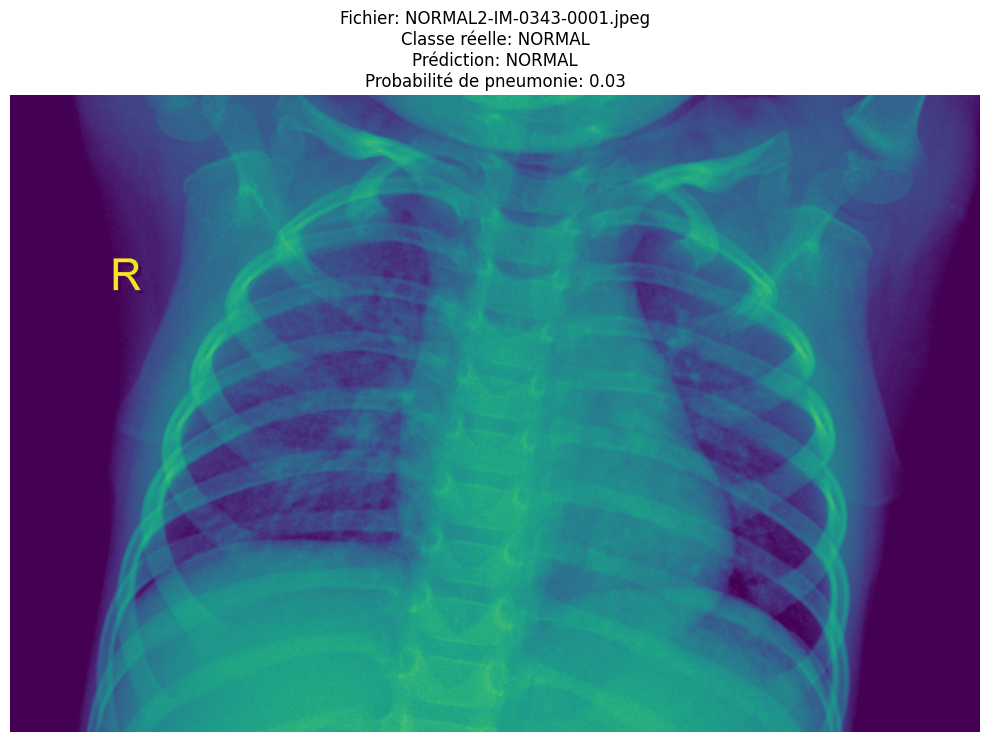

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


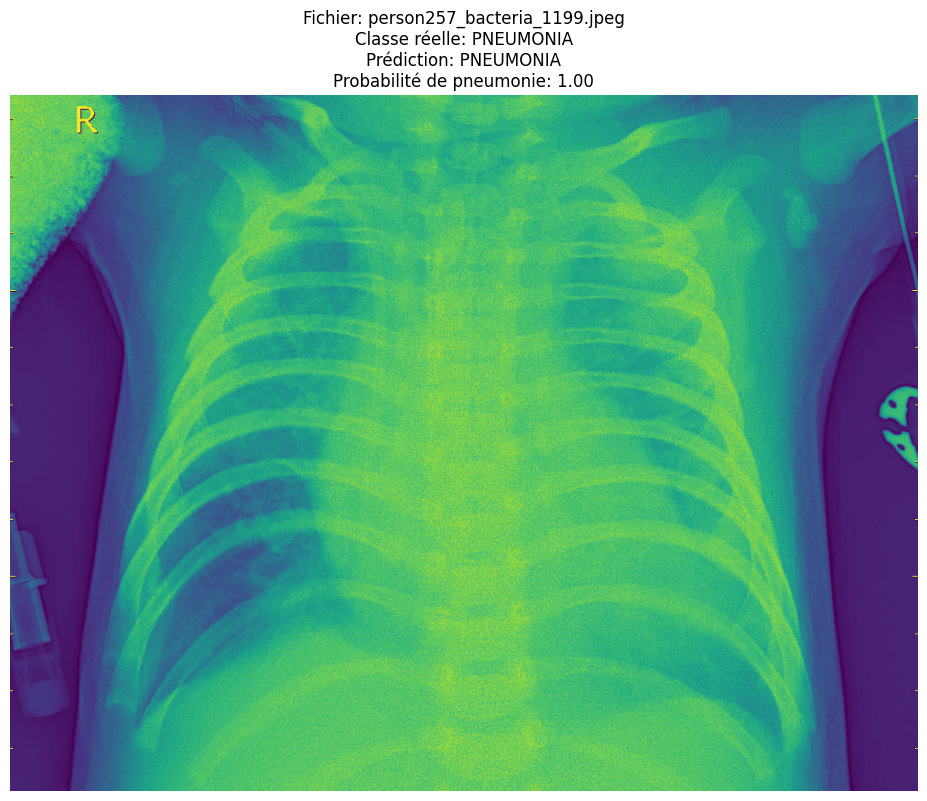

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


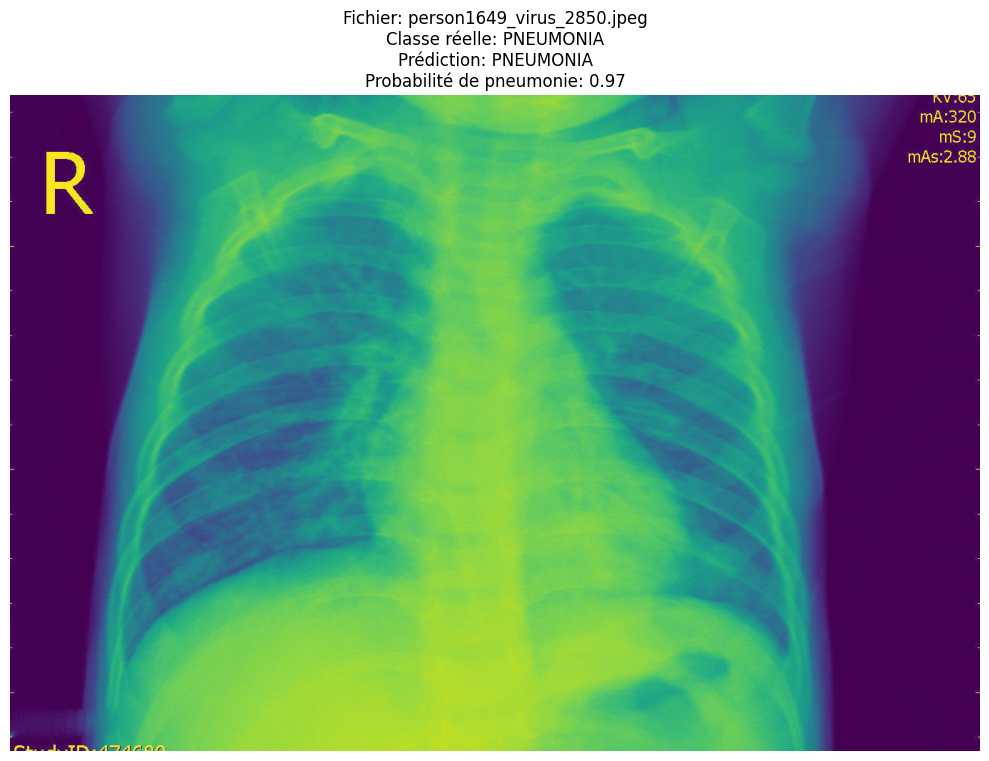

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


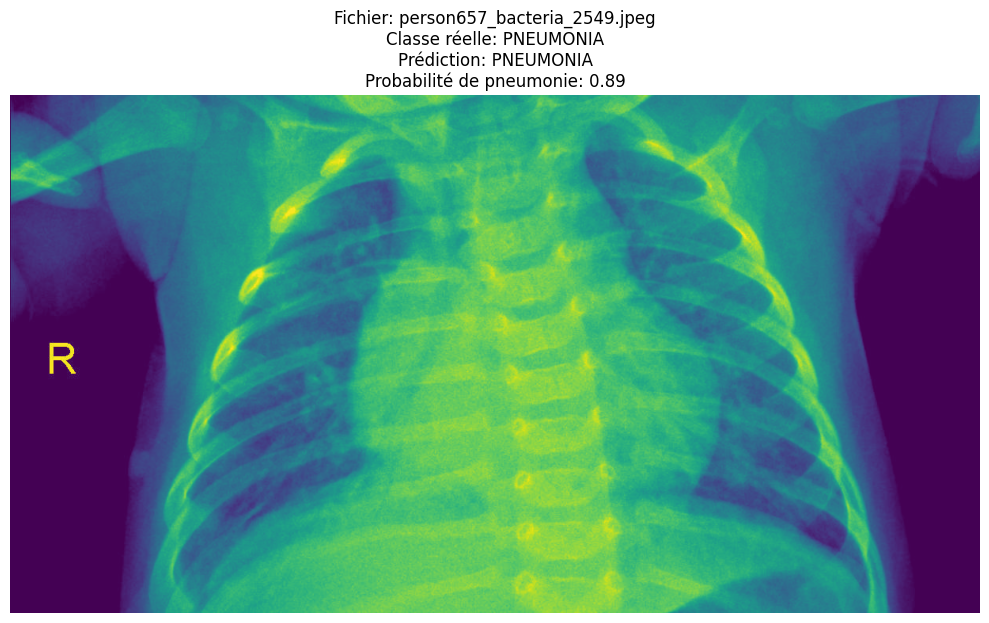

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


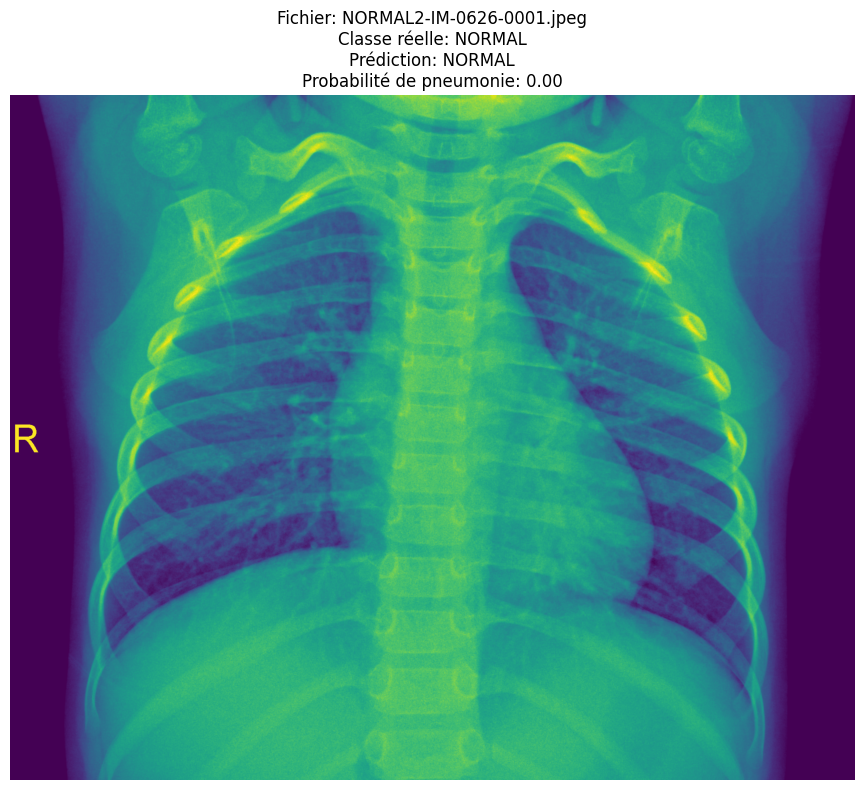

In [8]:
if __name__ == "__main__":
    model_vgg16 = create_vgg16_model()
    print("Résumé du modèle VGG16")
    model_vgg16.summary()
    epochs = 10
    history_vgg16 = model_vgg16.fit(
        traingenerator,
        epochs=epochs,
        validation_data=valgenerator,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, verbose=1)
        ]
    )
    plot_learning_curves(history_vgg16, "VGG16")
    model_vgg16.save("pneumonia_detection_vgg16.h5")

    # Évaluation sur le test set
    test_steps = testgenerator.samples // testgenerator.batch_size + 1
    print("Évaluation du modèle VGG16")
    testgenerator.reset()
    vgg16_loss, vgg16_acc = model_vgg16.evaluate(testgenerator, steps=test_steps)
    print(f"Précision du VGG16 sur le jeu de test : {vgg16_acc:.4f}")

    # Prédictions
    testgenerator.reset()
    y_pred_proba_vgg16 = model_vgg16.predict(testgenerator, steps=test_steps)
    y_pred_vgg16 = (y_pred_proba_vgg16 > 0.5).astype(int)
    y_true = testgenerator.classes[:len(y_pred_vgg16)]

    # Matrice de confusion et métriques
    metrics_vgg16 = plot_binary_confusion_matrix(y_true, y_pred_proba_vgg16, "VGG16")

    # Courbe ROC
    rocauc_vgg16 = plot_roc_curve(y_true, y_pred_proba_vgg16, "VGG16")
    print(f"AUC : {rocauc_vgg16:.3f}")

    # Prédictions sur images aléatoires
    print("Prédictions sur images aléatoires :")
    test_random_images(model_vgg16, testdir, num_images=5)

## 5. Entraînement et Évaluation du Modèle VGG16

### 🚀 Configuration de l'entraînement

```python
if __name__ == "__main__":
    # Création du modèle VGG16
    model_vgg16 = create_vgg16_model()
    
    print("\nRésumé du modèle VGG16:")
    model_vgg16.summary()
    
    # Entraînement du modèle
    epochs = 5
    
    # Entraînement du VGG16
    history_vgg16 = model_vgg16.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
        ],
        verbose=1)
```

### 📋 Callbacks utilisés

| Callback | Fonction | Paramètres |
|----------|----------|------------|
| **EarlyStopping** | Arrêt anticipé si pas d'amélioration | `patience=3`, `restore_best_weights=True` |
| **ReduceLROnPlateau** | Réduction du learning rate | `factor=0.2`, `patience=2` |

**Avantages :**
- 🛡️ **Protection contre le surapprentissage**
- ⚡ **Optimisation automatique du learning rate**
- 💾 **Conservation des meilleurs poids**

### 📊 Pipeline d'évaluation complète

```python
# Évaluation sur le jeu de test
test_steps = test_generator.samples // test_generator.batch_size + 1

# Évaluation du VGG16
print("\nÉvaluation du modèle VGG16:")
test_generator.reset()
vgg16_loss, vgg16_acc = model_vgg16.evaluate(test_generator, steps=test_steps)

# Obtenir les prédictions et les vraies étiquettes
test_generator.reset()
y_pred_proba_vgg16 = model_vgg16.predict(test_generator, steps=test_steps)
y_pred_vgg16 = (y_pred_proba_vgg16 > 0.5).astype(int)
y_true = test_generator.classes[:len(y_pred_vgg16)]

# Visualisations et analyses
plot_learning_curves(history_vgg16, "VGG16")
metrics_vgg16 = plot_binary_confusion_matrix(y_true, y_pred_proba_vgg16, "VGG16")
roc_auc_vgg16 = plot_roc_curve(y_true, y_pred_proba_vgg16, "VGG16")
results, all_predictions = analyze_pneumonia_predictions(model_vgg16, test_dir)
test_random_images(model_vgg16, test_dir, num_images=5)
```

### 💾 Sauvegarde et persistance

```python
# Sauvegarde du modèle
model_vgg16.save('pneumonia_detection_vgg16.h5')
```

**Important :** Le modèle est sauvegardé pour utilisation future sans réentraînement.

### 🎯 Workflow d'évaluation

1. **Entraînement** avec callbacks pour optimisation automatique
2. **Visualisation** des courbes d'apprentissage
3. **Évaluation quantitative** avec métriques multiples
4. **Analyse qualitative** avec images aléatoires
5. **Sauvegarde** du modèle entraîné

> 💡 **Note** : Cette approche méthodique garantit une évaluation complète et reproductible du modèle pour la classification de radiographies thoraciques.